# Bioinformatics 575 Group Project


***Lung Cancer Subtypes***

### Task 1 - Load the Data

In [1]:
#install GEOparse to load data set
#pip install GEOparse

In [2]:
#Access lung cancer data
#Link to data file: https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE10245

In [3]:
import GEOparse
gse = GEOparse.get_GEO(geo="GSE10245", destdir="./")

12-Nov-2023 20:20:26 DEBUG utils - Directory ./ already exists. Skipping.
12-Nov-2023 20:20:26 INFO GEOparse - File already exist: using local version.
12-Nov-2023 20:20:26 INFO GEOparse - Parsing ./GSE10245_family.soft.gz: 
12-Nov-2023 20:20:26 DEBUG GEOparse - DATABASE: GeoMiame
12-Nov-2023 20:20:26 DEBUG GEOparse - SERIES: GSE10245
12-Nov-2023 20:20:26 DEBUG GEOparse - PLATFORM: GPL570
/Users/xinli/opt/miniconda3/lib/python3.9/site-packages/GEOparse/GEOparse.py:401: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  return read_csv(StringIO(data), index_col=None, sep="\t")
12-Nov-2023 20:20:28 DEBUG GEOparse - SAMPLE: GSM258551
12-Nov-2023 20:20:28 DEBUG GEOparse - SAMPLE: GSM258552
12-Nov-2023 20:20:28 DEBUG GEOparse - SAMPLE: GSM258553
12-Nov-2023 20:20:28 DEBUG GEOparse - SAMPLE: GSM258554
12-Nov-2023 20:20:28 DEBUG GEOparse - SAMPLE: GSM258555
12-Nov-2023 20:20:28 DEBUG GEOparse - SAMPLE: GSM258556
12-Nov-2023 20:20:28 DEBUG GEO

In [4]:
# sklearn.cluster module link: https://scikit-learn.org/stable/modules/clustering.html#k-means
# K-Means Algorithm link: https://www.tutorialspoint.com/machine_learning_with_python/machine_learning_with_python_clustering_algorithms_k_means.htm

In [5]:
import pandas as pd
data = gse.pivot_samples('VALUE')
df = data.T

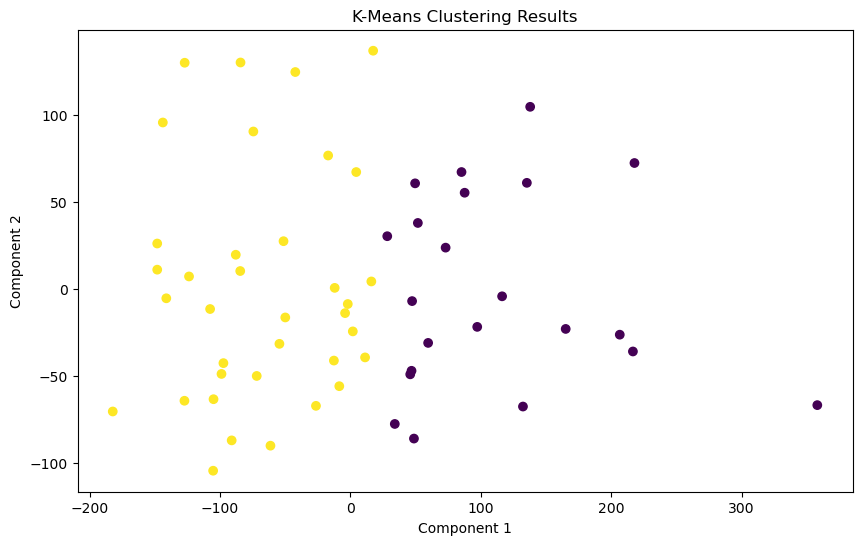

In [7]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)

kmeans = KMeans(n_clusters=2, n_init=10, random_state=42)
cluster_labels = kmeans.fit_predict(df_scaled)

# optional for dimensionality reduction
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(df_scaled)

plt.figure(figsize=(10, 6))
#plt.scatter(df_scaled[:, 0], df_scaled[:, 1], c=cluster_labels, cmap='viridis')
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=cluster_labels, cmap='viridis')

plt.title("K-Means Clustering Results")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.show()

In [8]:
df["cluster"] = cluster_labels
subtypes = []
for sample_id, sample in gse.gsms.items():
    #print(sample.metadata)
    subtype_info = sample.metadata.get('characteristics_ch1', [''])[0]
    # Process the subtype_info to extract the actual subtype
    # This might involve string parsing if the information is in a specific format
    subtypes.append([sample_id, subtype_info.replace("disease state: ","")])
subtypes_df = pd.DataFrame(subtypes, columns=['Name', 'Type'])
subtypes_df.set_index('Name', inplace=True)
merge_df = pd.merge(subtypes_df, df, left_index=True, right_index=True)
cluster_df = merge_df[['Type', 'cluster']]
cluster_df.head()

,Type,cluster
Name,,
GSM258551,adenocarcinoma,0
GSM258552,adenocarcinoma,1
GSM258553,squamous cell carcinoma,0
GSM258554,adenocarcinoma,0
GSM258555,squamous cell carcinoma,1


In [9]:
from sklearn.metrics import confusion_matrix, accuracy_score

cluster_df.loc[:, 'Predicted_Label'] = cluster_df['cluster'].map({1: 'adenocarcinoma', 0: 'squamous cell carcinoma'})
conf_matrix = confusion_matrix(cluster_df['Type'], cluster_df['Predicted_Label'])

accuracy = accuracy_score(cluster_df['Type'], cluster_df['Predicted_Label'])
#print("Confusion Matrix:\n", conf_matrix)
print("Accuracy:", accuracy)


Accuracy: 0.5172413793103449


/var/folders/rx/ny1j8gd54cbc25g248twqkb40000gn/T/ipykernel_1507/511328927.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_df.loc[:, 'Predicted_Label'] = cluster_df['cluster'].map({1: 'adenocarcinoma', 0: 'squamous cell carcinoma'})


In [ ]:
# 5. Fit the model on half of the data (balanced: 20 AD and 9 SCC) and
# assign a label to the clusters (AD or SCC), 
# then use the model to predict the cluster/label for the other half of the data.

from sklearn.model_selection import train_test_split

# get original data of df in question 1
expression_df = df.drop(columns=["cluster"])
# print(expression_df.head())

subtype_df = subtypes_df

# Merging the expression data with subtype information
merged_df = pd.merge(expression_df, subtype_df, left_on='name', right_on='Name')
# print(merged_df.head())

# Splitting the data into adenocarcinoma (AD) and squamous cell carcinoma (SCC)
ad_df = merged_df[merged_df["Type"] == "adenocarcinoma"]
# print(ad_df.head())
scc_df = merged_df[merged_df["Type"] == "squamous cell carcinoma"]

# Splitting each subtype into two halves for training and testing
ad_train, ad_test = train_test_split(ad_df, test_size=0.5, random_state=42)
scc_train, scc_test = train_test_split(scc_df, test_size=0.5, random_state=42)

# Combining the halves to create training and testing datasets
train_df = pd.concat([ad_train, scc_train])
# print(train_df)
test_df = pd.concat([ad_test, scc_test])
print(test_df)


X_train = train_df.drop(columns=["Type"])
# print(X_train.head())

# Training the KMeans model on the first half of the data
kmeans_train = KMeans(n_clusters=2, n_init=10, random_state=42)
kmeans_train.fit(X_train)

# Preparing the test data (features only)
X_test = test_df.drop(columns=["Type"])

# Predicting the cluster labels for the second half
test_cluster_labels = kmeans_train.predict(X_test)
# print(test_cluster_labels)

# Mapping cluster numbers to subtype labels. Just like question 4
train_df['cluster'] = kmeans_train.labels_

# print(train_df)
cluster_0_subtype = train_df[train_df['cluster'] == 0]['Type'].mode()[0] #find the most common type when cluster = 0
cluster_1_subtype = train_df[train_df['cluster'] == 1]['Type'].mode()[0]
test_predicted_labels = pd.Series(test_cluster_labels).map({0: cluster_0_subtype, 1: cluster_1_subtype})
print(test_predicted_labels)

# Evaluating the performance on the test data, just like question 4....
test_accuracy = accuracy_score(test_df["Type"], test_predicted_labels)


print("Test Accuracy:", test_accuracy)